In [219]:
# 라이브러리 임포트
import os
import pandas as pd
import chardet

# 사용자 정의함수 경로 설정
import sys
sys.path.append("G:/내 드라이브/Source/_Custom_Function")
# 사용자 정의함수 불러오기

import time

import ExcelFile_Merge as em
import ExcelFile_Read as er
import ExcelFile_EDA as ee

## 기본 데이터 불러오기

In [222]:
_year = '2023'

In [224]:
start_time = time.time()
df_BikeRent = pd.read_parquet('G:\\내 드라이브\\DataSet\\_파킷 파일\\서울특별시 공공자전거 대여이력 정보\\서울특별시 공공자전거 대여이력 정보_' + _year + '_preprocessed.parquet')
print("read_csv time :", time.time() - start_time)

OSError: [Errno 22] Invalid argument

In [4]:
df_BikeRent.head(3)

,자전거번호,대여대여소번호,대여대여소명,대여거치대,반납대여소번호,반납대여소명,반납거치대,이용시간(분),이용거리(M),대여일자,대여시간,반납일자,반납시간,대여시간차,이용시간-대여시간차,이용속도(km/h)
0,SPB-46712,04804,동서울농협 앞,0,01416,상봉역 3번출구,0,1,0.00,2024-01-01,00:04:10,2024-01-01,00:05:13,0 days 00:01:03,-0.050000,0.0000
1,SPB-35089,04169,신대방삼거리,0,00251,서울지방병무청 버스정류장,0,6,1147.58,2024-01-01,00:00:10,2024-01-01,00:06:23,0 days 00:06:13,-0.216667,11.4758
2,SPB-36386,00540,군자역 7번출구 베스트샵 앞,0,03509,세종사이버대학교,0,3,642.13,2024-01-01,00:03:13,2024-01-01,00:06:33,0 days 00:03:20,-0.333333,12.8426


In [5]:
df_BikeRent.shape[0]

21621807

In [6]:
start_time = time.time()
df_BikeBroken = pd.read_parquet('G:\\내 드라이브\\DataSet\\_최종 병합 파일\\서울시 공공자전거 고장신고 내역_15-24.06.parquet')
print("read_csv time :", time.time() - start_time)

read_csv time : 0.4247398376464844


In [7]:
df_BikeBroken.head(3)

,자전거번호,고장구분,등록일자,등록시간
0,SPB-00108,체인,2015-12-04,07:41:01
1,SPB-00210,체인,2015-12-07,12:23:33
2,SPB-00035,기타,2015-12-09,17:07:00


In [8]:
df_BikeBroken.shape[0]

767715

---
### df_BikeRent 의 데이터를 조건에 재조회
- 대여시간차가 5분 미만인 데이터
- 대여 대여소 번호와 반납 대여소 번호가 동일한 데이터

In [10]:
# 1. 조건에 따라 필터링: 대여시간차가 5분 미만, 대여 대여소 번호와 반납 대여소 번호가 동일한 데이터만 선택
cond1 = df_BikeRent['대여시간차'] < pd.Timedelta(minutes=5)
cond2 = df_BikeRent['대여대여소번호'] == df_BikeRent['반납대여소번호']
df_BikeRent_2 = df_BikeRent[cond1 & cond2].copy()

# 대여일자를 날짜 형식으로 변환 (필요한 경우)
df_BikeRent_2['대여일자'] = pd.to_datetime(df_BikeRent_2['대여일자'])

In [11]:
df_BikeRent_2.shape[0]

714084

In [12]:
df_BikeRent_2.head(3)

,자전거번호,대여대여소번호,대여대여소명,대여거치대,반납대여소번호,반납대여소명,반납거치대,이용시간(분),이용거리(M),대여일자,대여시간,반납일자,반납시간,대여시간차,이용시간-대여시간차,이용속도(km/h)
5,SPB-67162,00226,샛강역 1번출구 앞,0,00226,샛강역 1번출구 앞,0,1,20.0,2024-01-01,00:06:16,2024-01-01,00:07:35,0 days 00:01:19,-0.316667,1.2
9,SPB-63233,01601,석계역 문화광장 내 자전거 보관소,0,01601,석계역 문화광장 내 자전거 보관소,0,0,0.0,2024-01-01,00:07:59,2024-01-01,00:08:16,0 days 00:00:17,-0.283333,NaN
10,SPB-51653,05768,방이삼거리,0,05768,방이삼거리,0,0,0.0,2024-01-01,00:07:49,2024-01-01,00:08:25,0 days 00:00:36,-0.600000,NaN


---
### '자전거번호' 기준으로 각 데이터 사이별로 '대여일자'간의 차이를 계산하여 '대여사이기간' 컬럼 생성

In [14]:
start_time = time.time()

# 2. 대여일자 간의 차이를 계산하여 대여사이기간 구하기
all_intervals = []

for bike_id, group in df_BikeRent_2.groupby('자전거번호'):
    group = group.sort_values('대여일자').reset_index(drop=True) # 대여일자 기준으로 재정렬, 인덱스는 처음부터 재 설정
    # 현재 행과 이전 행 간의 차이를 계산합니다. 이 경우, '대여일자' 열에 대해 연속된 날짜 간의 차이를 계산합니다.
    group['대여사이기간'] = group['대여일자'].diff()
    
    # 대여사이기간 데이터만 저장
    for i in range(1, len(group)):
        start_date = group['대여일자'].iloc[i - 1]
        end_date = group['대여일자'].iloc[i]
        interval = group['대여사이기간'].iloc[i]
        
        all_intervals.append({
            '자전거번호': bike_id,
            '기간 시작일': start_date,
            '기간 종료일': end_date,
            '대여사이기간': interval
        })

# DataFrame으로 변환
df_BikeRent_3 = pd.DataFrame(all_intervals)

print("check time :", time.time() - start_time)

In [15]:
df_BikeRent_3.shape[0]

672453

In [16]:
df_BikeRent_3.head(3)

,자전거번호,기간 시작일,기간 종료일,대여사이기간
0,SPB-30001,2024-02-08,2024-03-06,27 days
1,SPB-30001,2024-03-06,2024-03-14,8 days
2,SPB-30001,2024-03-14,2024-05-02,49 days


### 중복제거

In [18]:
df_BikeRent_3 = df_BikeRent_3.drop_duplicates()

In [19]:
df_BikeRent_3.shape[0]

594308

In [20]:
df_BikeRent_3.head(3)

,자전거번호,기간 시작일,기간 종료일,대여사이기간
0,SPB-30001,2024-02-08,2024-03-06,27 days
1,SPB-30001,2024-03-06,2024-03-14,8 days
2,SPB-30001,2024-03-14,2024-05-02,49 days


---
### 자전거 대여이력과 고장신고 데이터를 비교

In [22]:
df_BikeRent_3.head(2)

,자전거번호,기간 시작일,기간 종료일,대여사이기간
0,SPB-30001,2024-02-08,2024-03-06,27 days
1,SPB-30001,2024-03-06,2024-03-14,8 days


In [23]:
df_BikeBroken.head(2)

,자전거번호,고장구분,등록일자,등록시간
0,SPB-00108,체인,2015-12-04,07:41:01
1,SPB-00210,체인,2015-12-07,12:23:33


In [24]:
df_BikeBroken['등록일자'] = pd.to_datetime(df_BikeBroken['등록일자'])

In [25]:
df_BikeBroken.head()

,자전거번호,고장구분,등록일자,등록시간
0,SPB-00108,체인,2015-12-04,07:41:01
1,SPB-00210,체인,2015-12-07,12:23:33
2,SPB-00035,기타,2015-12-09,17:07:00
3,SPB-01024,기타,2015-12-13,21:02:24
4,SPB-01015,기타,2015-12-28,10:12:04


In [26]:
print(f'자전거 대여이력 데이터 : {df_BikeRent_3.shape[0]}')
print(f'자전거 고장신고 데이터 : {df_BikeBroken.shape[0]}')

자전거 대여이력 데이터 : 594308
자전거 고장신고 데이터 : 767715


In [27]:
df_BikeRent_3.head(2)

,자전거번호,기간 시작일,기간 종료일,대여사이기간
0,SPB-30001,2024-02-08,2024-03-06,27 days
1,SPB-30001,2024-03-06,2024-03-14,8 days


In [28]:
print(df_BikeRent_3['기간 시작일'].min())
print(df_BikeRent_3['기간 시작일'].max())

2024-01-01 00:00:00
2024-06-30 00:00:00


In [29]:
print(df_BikeBroken['등록일자'].min())
print(df_BikeBroken['등록일자'].max())

2015-12-04 00:00:00
2024-06-30 00:00:00


---
### 2023년 고장신고 데이터만 조회

In [31]:
df_BikeBroken = df_BikeBroken[df_BikeBroken['등록일자'].between('2023-01-01', '2023-12-31')]

In [32]:
df_BikeBroken.shape[0]

76463

In [33]:
df_BikeBroken.head(2)

,자전거번호,고장구분,등록일자,등록시간
691252,SPB-40704,단말기,2024-01-01,03:57:03
691253,SPB-65171,기타,2024-01-01,04:15:59


In [34]:
correlated_bikes = []

start_time = time.time()
# "자전거 대여이력" 데이터만큼 반복
for _, row in df_BikeRent_3.iterrows():
    bike_id = row['자전거번호']
    start_date = row['기간 시작일']
    end_date = row['기간 종료일']

    # "자전거 대여이력"의 등록일자 사이에, "고장신고 내역"이 있는 경우 체크
    date_in_range = df_BikeBroken[
        (df_BikeBroken['자전거번호'] == bike_id) &
        (df_BikeBroken['등록일자'] >= start_date) &
        (df_BikeBroken['등록일자'] <= end_date)
    ]
    
    correlated_bikes.append({
        '자전거번호': bike_id,
        '최초_대여시작': start_date,
        '마지막_대여시작': end_date,
        '대여사이기간': row['대여사이기간'],
        '최초_고장신고': date_in_range.iloc[0]['등록일자'] if len(date_in_range) else None,
        '마지막_고장신고': date_in_range.iloc[-1]['등록일자'] if len(date_in_range) else None,
        '전체_고장신고': date_in_range['등록일자'].tolist() if len(date_in_range) else None,
        '횟수_고장신고': len(date_in_range) if len(date_in_range) else 0
    })

print("correlated_bikes time :", time.time() - start_time)

# 결과를 데이터프레임으로 변환
final_result_df = pd.DataFrame(correlated_bikes)

correlated_bikes time : 2712.6987285614014


In [35]:
final_result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594308 entries, 0 to 594307
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype          
---  ------    --------------   -----          
 0   자전거번호     594308 non-null  object         
 1   최초_대여시작   594308 non-null  datetime64[ns] 
 2   마지막_대여시작  594308 non-null  datetime64[ns] 
 3   대여사이기간    594308 non-null  timedelta64[ns]
 4   최초_고장신고   83425 non-null   datetime64[ns] 
 5   마지막_고장신고  83425 non-null   datetime64[ns] 
 6   전체_고장신고   83425 non-null   object         
 7   횟수_고장신고   594308 non-null  int64          
dtypes: datetime64[ns](4), int64(1), object(2), timedelta64[ns](1)
memory usage: 36.3+ MB


In [36]:
final_result_df.head()

,자전거번호,최초_대여시작,마지막_대여시작,대여사이기간,최초_고장신고,마지막_고장신고,전체_고장신고,횟수_고장신고
0,SPB-30001,2024-02-08,2024-03-06,27 days,NaT,NaT,None,0
1,SPB-30001,2024-03-06,2024-03-14,8 days,NaT,NaT,None,0
2,SPB-30001,2024-03-14,2024-05-02,49 days,NaT,NaT,None,0
3,SPB-30001,2024-05-02,2024-05-03,1 days,NaT,NaT,None,0
4,SPB-30001,2024-05-03,2024-05-19,16 days,NaT,NaT,None,0


---
### 추가 컬럼 생성

In [38]:
final_result_df_2 = final_result_df

In [39]:
final_result_df_2['고장사이기간'] = final_result_df_2['마지막_고장신고'] - final_result_df_2['최초_고장신고']
final_result_df_2['고장신고_대기'] = final_result_df_2['최초_고장신고'] - final_result_df_2['최초_대여시작']

In [40]:
# '고장여부' 컬럼 생성: '횟수고장신고'가 0이면 0, 0보다 크면 1
final_result_df['고장여부'] = (final_result_df['횟수_고장신고'] > 0).astype(int)

In [41]:
final_result_df_2.shape[0]

594308

In [42]:
final_result_df_2.head()

,자전거번호,최초_대여시작,마지막_대여시작,대여사이기간,최초_고장신고,마지막_고장신고,전체_고장신고,횟수_고장신고,고장사이기간,고장신고_대기,고장여부
0,SPB-30001,2024-02-08,2024-03-06,27 days,NaT,NaT,None,0,NaT,NaT,0
1,SPB-30001,2024-03-06,2024-03-14,8 days,NaT,NaT,None,0,NaT,NaT,0
2,SPB-30001,2024-03-14,2024-05-02,49 days,NaT,NaT,None,0,NaT,NaT,0
3,SPB-30001,2024-05-02,2024-05-03,1 days,NaT,NaT,None,0,NaT,NaT,0
4,SPB-30001,2024-05-03,2024-05-19,16 days,NaT,NaT,None,0,NaT,NaT,0


In [43]:
final_result_df_2.columns

Index(['자전거번호', '최초_대여시작', '마지막_대여시작', '대여사이기간', '최초_고장신고', '마지막_고장신고',
       '전체_고장신고', '횟수_고장신고', '고장사이기간', '고장신고_대기', '고장여부'],
      dtype='object')

In [44]:
# 결과 출력
_columns = ['자전거번호', 
            '최초_대여시작', '마지막_대여시작', '대여사이기간', 
            '최초_고장신고', '마지막_고장신고', '고장사이기간', '전체_고장신고', '횟수_고장신고'
            , '고장신고_대기', '고장여부']
display(final_result_df_2[_columns].head(5))

,자전거번호,최초_대여시작,마지막_대여시작,대여사이기간,최초_고장신고,마지막_고장신고,고장사이기간,전체_고장신고,횟수_고장신고,고장신고_대기,고장여부
0,SPB-30001,2024-02-08,2024-03-06,27 days,NaT,NaT,NaT,None,0,NaT,0
1,SPB-30001,2024-03-06,2024-03-14,8 days,NaT,NaT,NaT,None,0,NaT,0
2,SPB-30001,2024-03-14,2024-05-02,49 days,NaT,NaT,NaT,None,0,NaT,0
3,SPB-30001,2024-05-02,2024-05-03,1 days,NaT,NaT,NaT,None,0,NaT,0
4,SPB-30001,2024-05-03,2024-05-19,16 days,NaT,NaT,NaT,None,0,NaT,0


In [45]:
final_result_df_2.isnull().mean()

자전거번호       0.000000
최초_대여시작     0.000000
마지막_대여시작    0.000000
대여사이기간      0.000000
최초_고장신고     0.859627
마지막_고장신고    0.859627
전체_고장신고     0.859627
횟수_고장신고     0.000000
고장사이기간      0.859627
고장신고_대기     0.859627
고장여부        0.000000
dtype: float64

---
### 각 데이터의 분포 확인

In [47]:
final_result_df_2.describe()

,최초_대여시작,마지막_대여시작,대여사이기간,최초_고장신고,마지막_고장신고,횟수_고장신고,고장사이기간,고장신고_대기,고장여부
count,594308,594308,594308,83425,83425,594308.000000,83425,83425,594308.000000
mean,2024-04-11 07:54:23.931833088,2024-04-20 02:36:35.273831168,8 days 18:42:11.341997752,2024-04-19 18:52:46.273899008,2024-04-20 20:18:03.473779456,0.177718,1 days 01:25:17.199880131,4 days 15:01:55.346718609,0.140373
min,2024-01-01 00:00:00,2024-01-01 00:00:00,0 days 00:00:00,2024-01-01 00:00:00,2024-01-01 00:00:00,0.000000,0 days 00:00:00,0 days 00:00:00,0.000000
25%,2024-03-08 00:00:00,2024-03-20 00:00:00,1 days 00:00:00,2024-03-22 00:00:00,2024-03-24 00:00:00,0.000000,0 days 00:00:00,0 days 00:00:00,0.000000
50%,2024-04-17 00:00:00,2024-04-26 00:00:00,4 days 00:00:00,2024-04-27 00:00:00,2024-04-28 00:00:00,0.000000,0 days 00:00:00,1 days 00:00:00,0.000000
75%,2024-05-21 00:00:00,2024-05-28 00:00:00,11 days 00:00:00,2024-05-27 00:00:00,2024-05-28 00:00:00,0.000000,0 days 00:00:00,5 days 00:00:00,0.000000
max,2024-06-30 00:00:00,2024-06-30 00:00:00,175 days 00:00:00,2024-06-30 00:00:00,2024-06-30 00:00:00,13.000000,174 days 00:00:00,160 days 00:00:00,1.000000
std,NaN,NaN,12 days 21:16:30.765850531,NaN,NaN,0.498493,5 days 09:07:35.748123756,9 days 08:15:31.091664623,0.347374


---
### 데이터 분포 시각화

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (Windows에서는 'Malgun Gothic' 사용)
plt.rcParams['font.family'] = 'Malgun Gothic'
# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

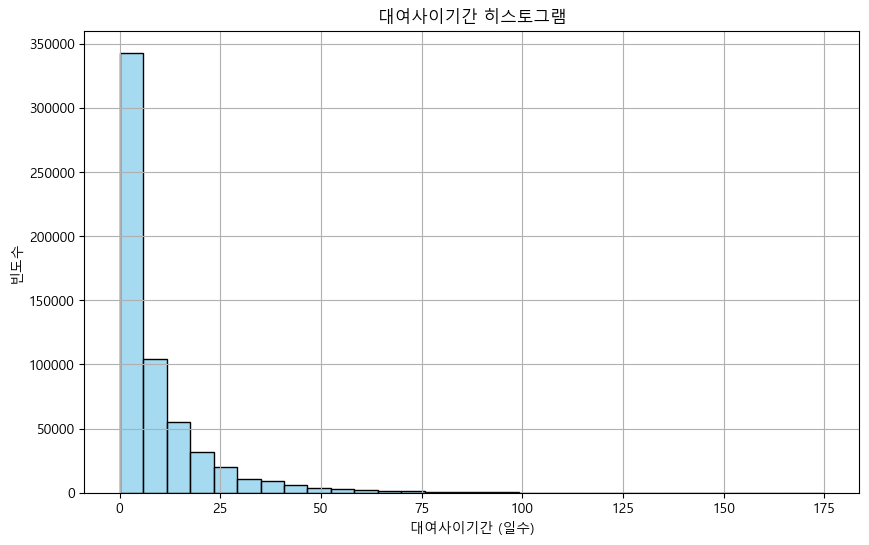

In [50]:
# '대여사이기간'을 일수로 변환하여 히스토그램 생성
plt.figure(figsize=(10, 6))
sns.histplot(final_result_df_2['대여사이기간'].dt.days.dropna(), bins=30, kde=False, color='skyblue')
plt.title('대여사이기간 히스토그램')
plt.xlabel('대여사이기간 (일수)')
plt.ylabel('빈도수')
plt.grid()
plt.show()

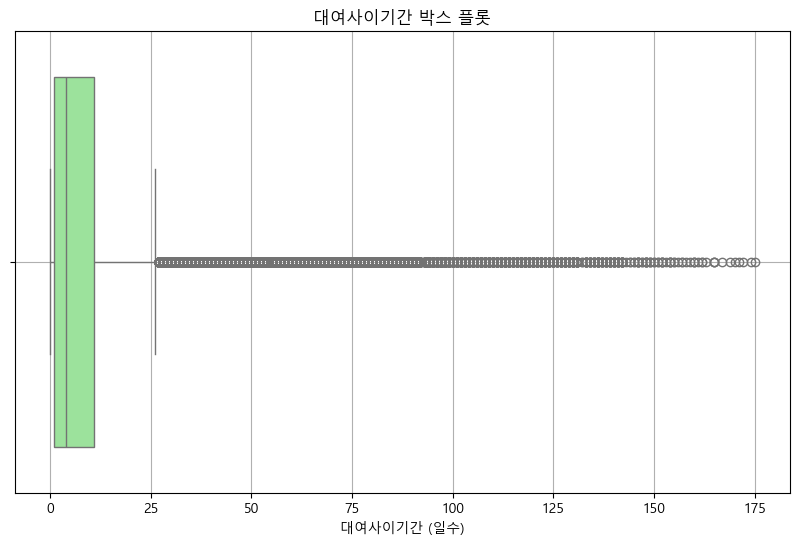

In [51]:
# 박스 플롯 생성
plt.figure(figsize=(10, 6))
sns.boxplot(x=final_result_df_2['대여사이기간'].dt.days.dropna(), color='lightgreen')
plt.title('대여사이기간 박스 플롯')
plt.xlabel('대여사이기간 (일수)')
plt.grid()
plt.show()

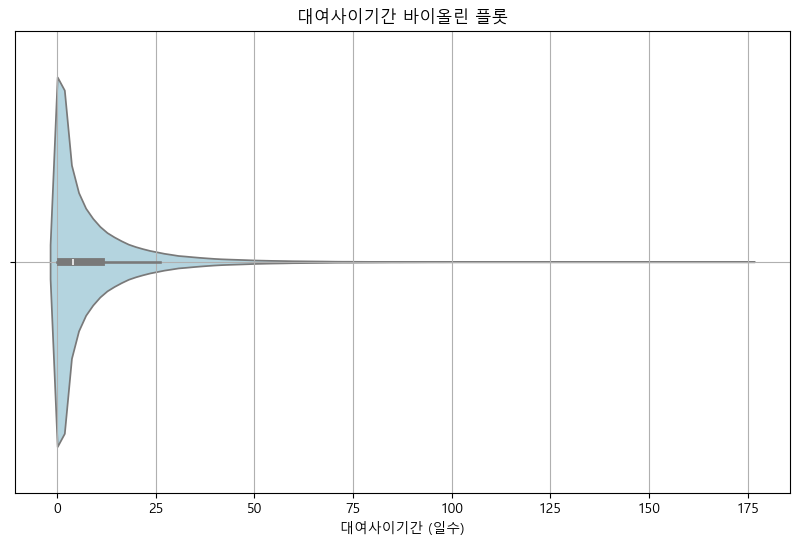

In [52]:
# 바이올린 플롯 생성
plt.figure(figsize=(10, 6))
sns.violinplot(x=final_result_df_2['대여사이기간'].dt.days.dropna(), color='lightblue')
plt.title('대여사이기간 바이올린 플롯')
plt.xlabel('대여사이기간 (일수)')
plt.grid()
plt.show()

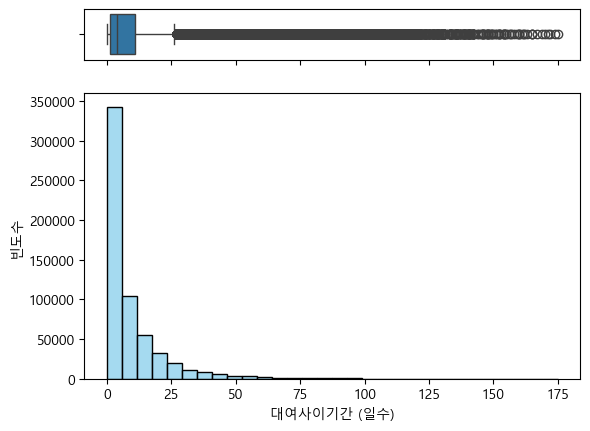

In [53]:
# 히스토그램과 박스 플롯을 함께 그리기
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.15, .85)})

# 박스 플롯
sns.boxplot(x=final_result_df_2['대여사이기간'].dt.days.dropna(), ax=ax_box)
ax_box.set(xlabel='')

# 히스토그램
sns.histplot(final_result_df_2['대여사이기간'].dt.days.dropna(), ax=ax_hist, bins=30, color='skyblue')
ax_hist.set(xlabel='대여사이기간 (일수)', ylabel='빈도수')

plt.show()

In [54]:
final_result_df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594308 entries, 0 to 594307
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype          
---  ------    --------------   -----          
 0   자전거번호     594308 non-null  object         
 1   최초_대여시작   594308 non-null  datetime64[ns] 
 2   마지막_대여시작  594308 non-null  datetime64[ns] 
 3   대여사이기간    594308 non-null  timedelta64[ns]
 4   최초_고장신고   83425 non-null   datetime64[ns] 
 5   마지막_고장신고  83425 non-null   datetime64[ns] 
 6   전체_고장신고   83425 non-null   object         
 7   횟수_고장신고   594308 non-null  int64          
 8   고장사이기간    83425 non-null   timedelta64[ns]
 9   고장신고_대기   83425 non-null   timedelta64[ns]
 10  고장여부      594308 non-null  int32          
dtypes: datetime64[ns](4), int32(1), int64(1), object(2), timedelta64[ns](3)
memory usage: 47.6+ MB


---
### 결측치 확인

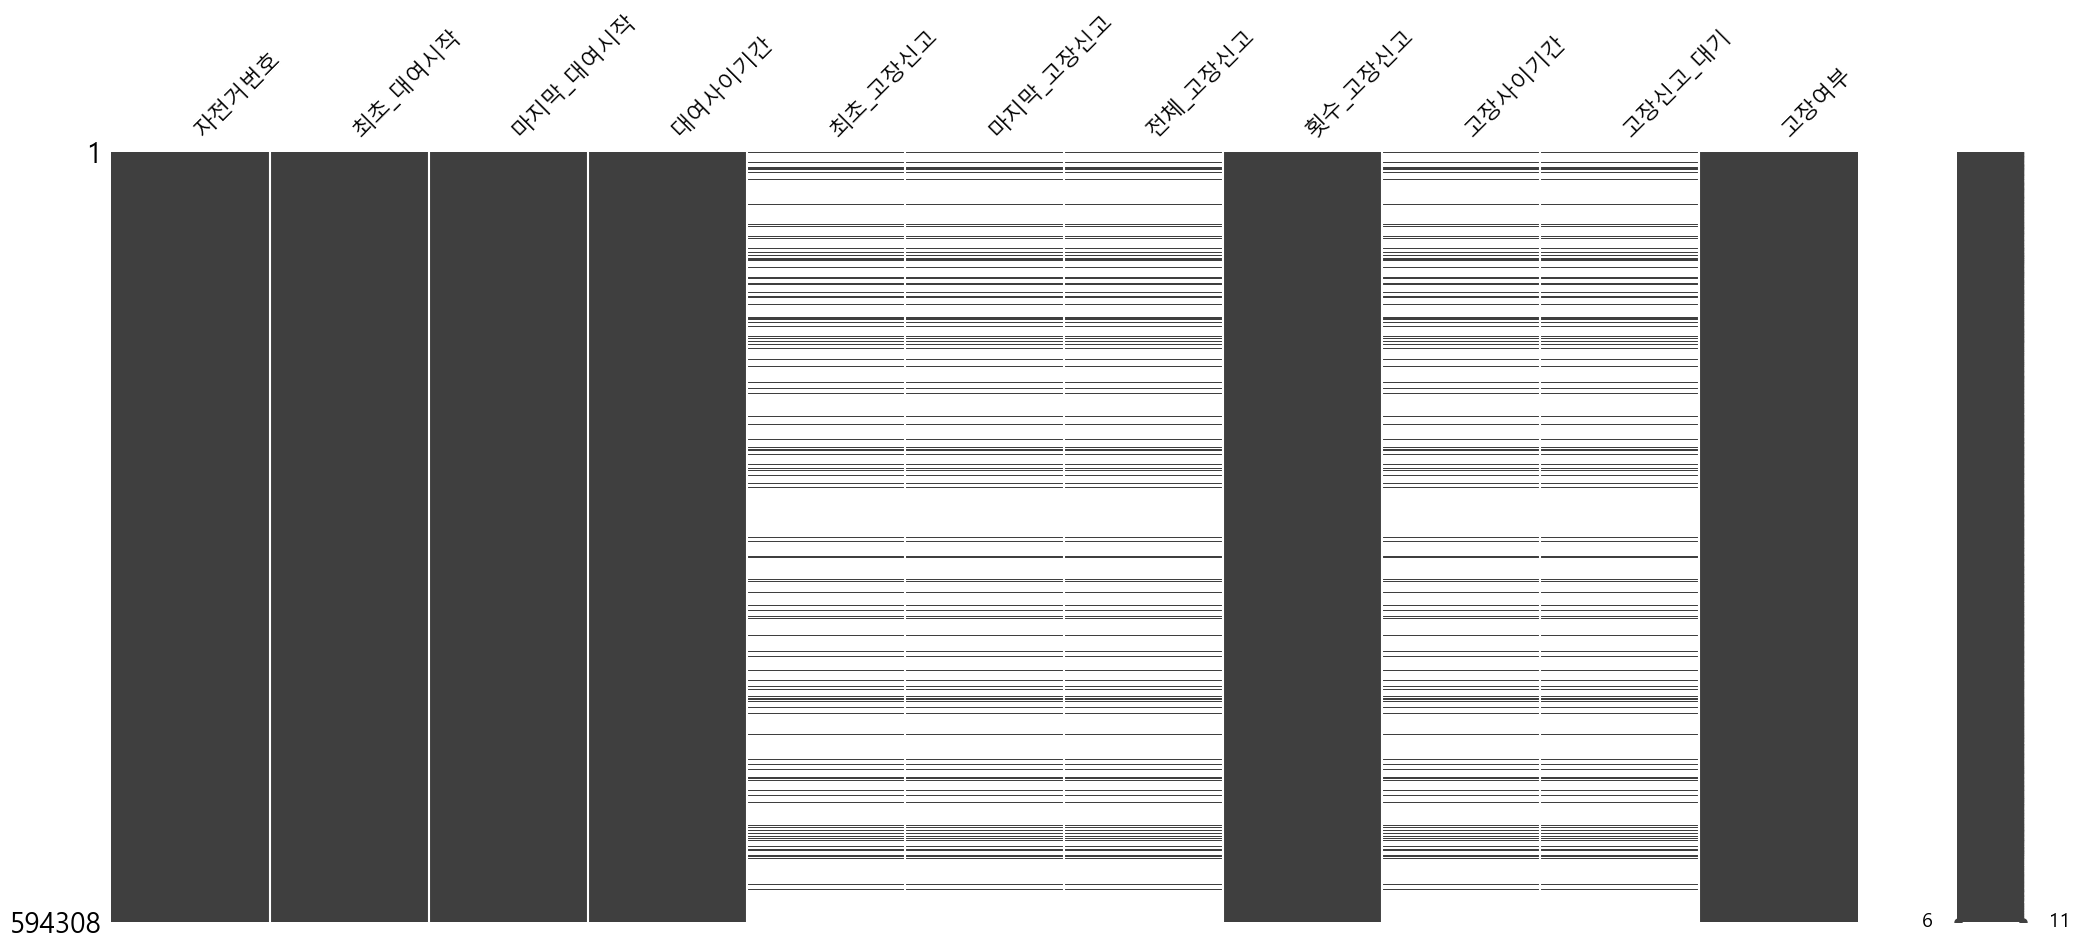

In [56]:
import missingno as msno
# 결측치 매트릭스 시각화
msno.matrix(final_result_df_2)
plt.show()

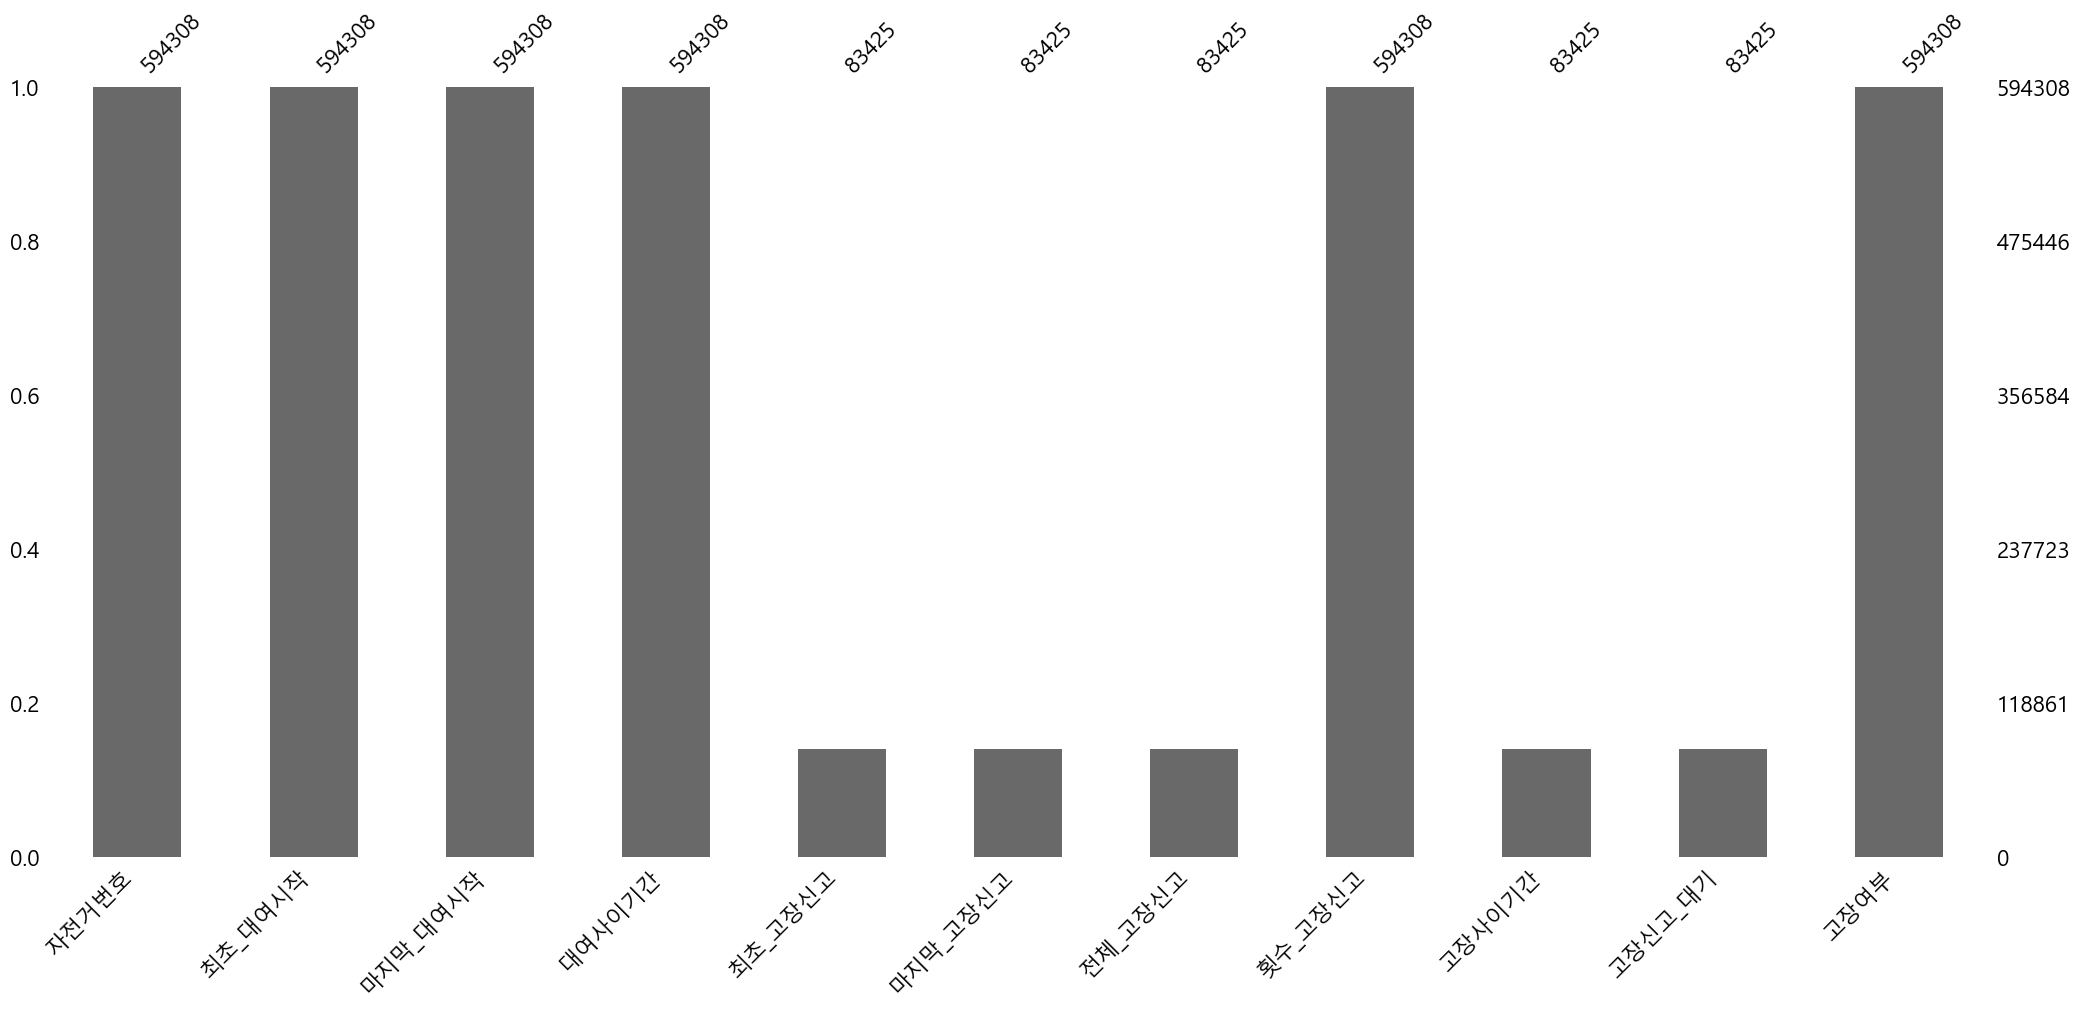

In [57]:
# 결측치 바 차트 시각화
msno.bar(final_result_df_2)
plt.show()

---
### 상관관계 확인

In [59]:
final_result_df_2.head(2)

,자전거번호,최초_대여시작,마지막_대여시작,대여사이기간,최초_고장신고,마지막_고장신고,전체_고장신고,횟수_고장신고,고장사이기간,고장신고_대기,고장여부
0,SPB-30001,2024-02-08,2024-03-06,27 days,NaT,NaT,None,0,NaT,NaT,0
1,SPB-30001,2024-03-06,2024-03-14,8 days,NaT,NaT,None,0,NaT,NaT,0


In [213]:
final_result_df_2.isnull().sum()

자전거번호       0
최초_대여시작     0
마지막_대여시작    0
대여사이기간      0
최초_고장신고     0
마지막_고장신고    0
전체_고장신고     0
횟수_고장신고     0
고장사이기간      0
고장신고_대기     0
고장여부        0
대여대기기간      0
dtype: int64

In [209]:
print(f'final_result_df_2 : {final_result_df_2.shape[0]}')
print(f'final_result_df_3 : {final_result_df_3.shape[0]}')

final_result_df_2 : 594308
final_result_df_3 : 594308


In [60]:
final_result_df_3 = final_result_df_2

In [61]:
# '대여사이기간', '고장사이기간', '고장신고_대기'를 timedelta로 변환 후 일수로 변환
final_result_df_3['대여사이기간'] = pd.to_timedelta(final_result_df_3['대여사이기간'], errors='coerce').dt.days
final_result_df_3['고장사이기간'] = pd.to_timedelta(final_result_df_3['고장사이기간'], errors='coerce').dt.days
final_result_df_3['고장신고_대기'] = pd.to_timedelta(final_result_df_3['고장신고_대기'], errors='coerce').dt.days

# 결측치는 0으로 채움 (필요에 따라 다른 값으로 처리 가능)
final_result_df_3.fillna(0, inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_8676\1368527007.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  final_result_df_3.fillna(0, inplace=True)


In [117]:
final_result_df_3.head()

,자전거번호,최초_대여시작,마지막_대여시작,대여사이기간,최초_고장신고,마지막_고장신고,전체_고장신고,횟수_고장신고,고장사이기간,고장신고_대기,고장여부
0,SPB-30001,2024-02-08,2024-03-06,27,0,0,0,0,0.0,0.0,0
1,SPB-30001,2024-03-06,2024-03-14,8,0,0,0,0,0.0,0.0,0
2,SPB-30001,2024-03-14,2024-05-02,49,0,0,0,0,0.0,0.0,0
3,SPB-30001,2024-05-02,2024-05-03,1,0,0,0,0,0.0,0.0,0
4,SPB-30001,2024-05-03,2024-05-19,16,0,0,0,0,0.0,0.0,0


In [189]:
final_result_df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594308 entries, 0 to 594307
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   자전거번호     594308 non-null  object        
 1   최초_대여시작   594308 non-null  datetime64[ns]
 2   마지막_대여시작  594308 non-null  datetime64[ns]
 3   대여사이기간    594308 non-null  int64         
 4   최초_고장신고   594308 non-null  object        
 5   마지막_고장신고  594308 non-null  object        
 6   전체_고장신고   594308 non-null  object        
 7   횟수_고장신고   594308 non-null  int64         
 8   고장사이기간    594308 non-null  float64       
 9   고장신고_대기   594308 non-null  float64       
 10  고장여부      594308 non-null  int32         
 11  대여대기기간    594308 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int32(1), int64(2), object(4)
memory usage: 52.1+ MB


In [154]:
# 새로운 컬럼 '대여대기기간' 생성
final_result_df_3['대여대기기간'] = final_result_df_3.apply(lambda x: x['대여사이기간'] if x['고장여부'] == 0 else x['고장신고_대기'], axis=1)

---
### 고장여부에 따른 분포확인

In [144]:
final_result_df_broken_O = final_result_df_3[final_result_df_3['고장여부'] == 1]   # 고장인 데이터
final_result_df_broken_X = final_result_df_3[final_result_df_3['고장여부'] == 0]   # 정상인 데이터

In [146]:
final_result_df_broken_O.describe()

,최초_대여시작,마지막_대여시작,대여사이기간,횟수_고장신고,고장사이기간,고장신고_대기,고장여부
count,83425,83425,83425.000000,83425.000000,83425.000000,83425.000000,83425.0
mean,2024-04-15 03:50:50.927180288,2024-04-28 03:03:05.253820672,12.966832,1.266035,1.059227,4.626335,1.0
min,2024-01-01 00:00:00,2024-01-01 00:00:00,0.000000,1.000000,0.000000,0.000000,1.0
25%,2024-03-16 00:00:00,2024-04-02 00:00:00,1.000000,1.000000,0.000000,0.000000,1.0
50%,2024-04-22 00:00:00,2024-05-04 00:00:00,7.000000,1.000000,0.000000,1.000000,1.0
75%,2024-05-22 00:00:00,2024-06-03 00:00:00,18.000000,1.000000,0.000000,5.000000,1.0
max,2024-06-30 00:00:00,2024-06-30 00:00:00,175.000000,13.000000,174.000000,160.000000,1.0
std,NaN,NaN,16.941993,0.626419,5.380275,9.344110,0.0


In [148]:
final_result_df_broken_X.describe()

,최초_대여시작,마지막_대여시작,대여사이기간,횟수_고장신고,고장사이기간,고장신고_대기,고장여부
count,510883,510883,510883.000000,510883.0,510883.0,510883.0,510883.0
mean,2024-04-10 16:53:35.176860416,2024-04-18 19:11:05.645167616,8.095492,0.0,0.0,0.0,0.0
min,2024-01-01 00:00:00,2024-01-01 00:00:00,0.000000,0.0,0.0,0.0,0.0
25%,2024-03-07 00:00:00,2024-03-18 00:00:00,1.000000,0.0,0.0,0.0,0.0
50%,2024-04-16 00:00:00,2024-04-25 00:00:00,4.000000,0.0,0.0,0.0,0.0
75%,2024-05-20 00:00:00,2024-05-27 00:00:00,10.000000,0.0,0.0,0.0,0.0
max,2024-06-30 00:00:00,2024-06-30 00:00:00,172.000000,0.0,0.0,0.0,0.0
std,NaN,NaN,11.957282,0.0,0.0,0.0,0.0


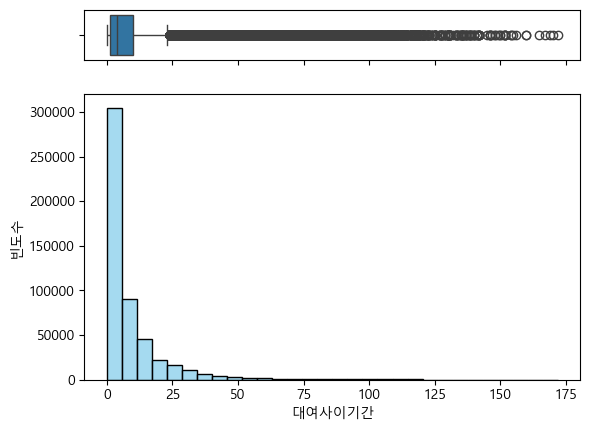

In [152]:
df_plot = final_result_df_broken_X
_column = '대여사이기간'

# 히스토그램과 박스 플롯을 함께 그리기
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.15, .85)})

# 박스 플롯
sns.boxplot(x=df_plot[_column], ax=ax_box)
ax_box.set(xlabel='')

# 히스토그램
sns.histplot(df_plot[_column], ax=ax_hist, bins=30, color='skyblue')
ax_hist.set(xlabel=_column, ylabel='빈도수')

plt.show()

In [158]:
final_result_df_3.head()

,자전거번호,최초_대여시작,마지막_대여시작,대여사이기간,최초_고장신고,마지막_고장신고,전체_고장신고,횟수_고장신고,고장사이기간,고장신고_대기,고장여부,대여대기기간
0,SPB-30001,2024-02-08,2024-03-06,27,0,0,0,0,0.0,0.0,0,27.0
1,SPB-30001,2024-03-06,2024-03-14,8,0,0,0,0,0.0,0.0,0,8.0
2,SPB-30001,2024-03-14,2024-05-02,49,0,0,0,0,0.0,0.0,0,49.0
3,SPB-30001,2024-05-02,2024-05-03,1,0,0,0,0,0.0,0.0,0,1.0
4,SPB-30001,2024-05-03,2024-05-19,16,0,0,0,0,0.0,0.0,0,16.0


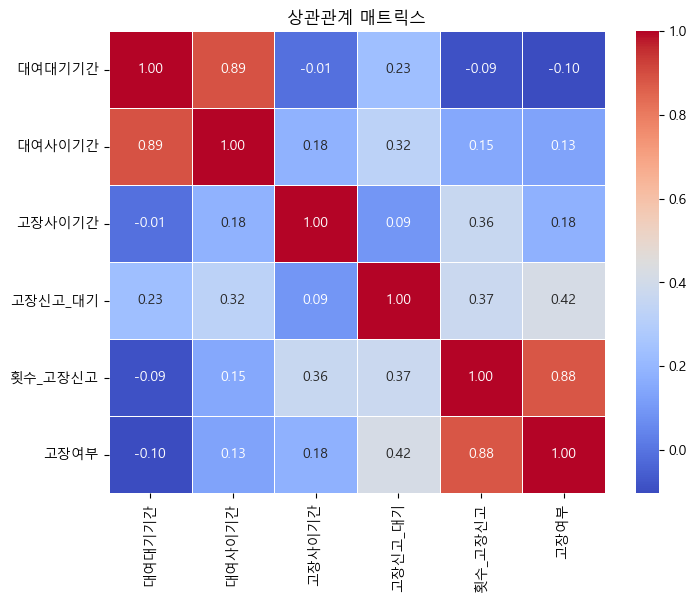

In [156]:
# 상관관계 계산
correlation_matrix = final_result_df_3[['대여대기기간', '대여사이기간', '고장사이기간', '고장신고_대기', '횟수_고장신고', '고장여부']].corr()

# 상관관계 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('상관관계 매트릭스')
plt.show()

---
### 이상치 제거

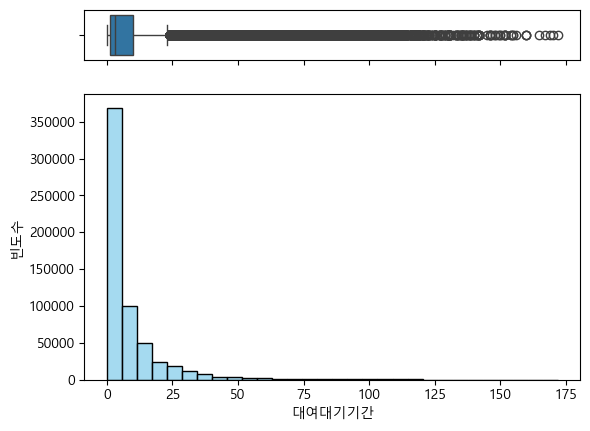

In [177]:
df_plot = final_result_df_3
_column = '대여대기기간'

# 히스토그램과 박스 플롯을 함께 그리기
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.15, .85)})

# 박스 플롯
sns.boxplot(x=df_plot[_column], ax=ax_box)
ax_box.set(xlabel='')

# 히스토그램
sns.histplot(df_plot[_column], ax=ax_hist, bins=30, color='skyblue')
ax_hist.set(xlabel=_column, ylabel='빈도수')

plt.show()

In [179]:
# 3. 대여사이기간 이상치 설정 및 필터링
Q1 = final_result_df_3['대여대기기간'].quantile(0.25)
Q3 = final_result_df_3['대여대기기간'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold = Q3 + 1.5 * IQR
outlier_intervals_df_1 = final_result_df_3[final_result_df_3['대여사이기간'] > outlier_threshold]
outlier_intervals_df_2 = final_result_df_3[final_result_df_3['대여사이기간'] <= outlier_threshold]

In [195]:
print(f'이상치 상단 값 : {outlier_threshold}')

이상치 상단 값 : 23.5


In [197]:
print(f'전체 데이터 : {final_result_df_3.shape[0]}')
print(f'이상치 데이터 : {outlier_intervals_df_1.shape[0]}')
print(f'정상 데이터 : {outlier_intervals_df_2.shape[0]}')

전체 데이터 : 594308
이상치 데이터 : 59335
정상 데이터 : 534973


In [216]:
outlier_intervals_df_1.head(2)

,자전거번호,최초_대여시작,마지막_대여시작,대여사이기간,최초_고장신고,마지막_고장신고,전체_고장신고,횟수_고장신고,고장사이기간,고장신고_대기,고장여부,대여대기기간
0,SPB-30001,2024-02-08,2024-03-06,27,0,0,0,0,0.0,0.0,0,27.0
2,SPB-30001,2024-03-14,2024-05-02,49,0,0,0,0,0.0,0.0,0,49.0


### 이상치 데이터의 고장 비율 확인

In [201]:
outlier_intervals_df_1['고장여부'].value_counts()

고장여부
0    44273
1    15062
Name: count, dtype: int64

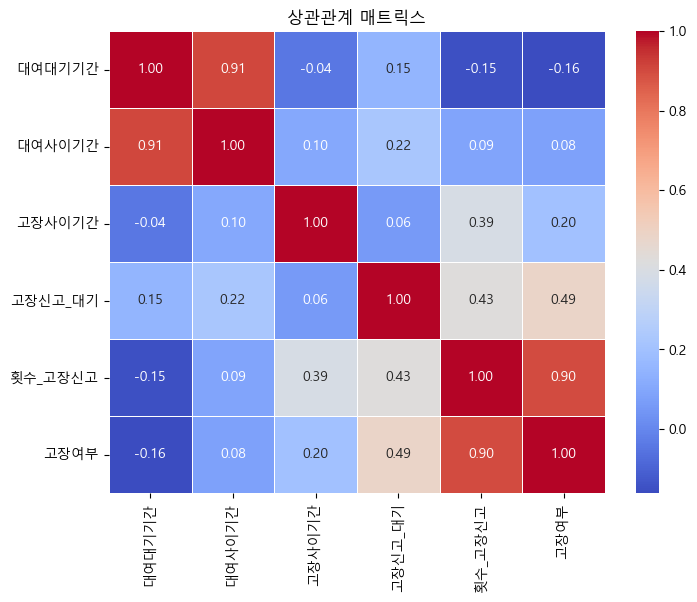

In [187]:
# 상관관계 계산
correlation_matrix = outlier_intervals_df_2[['대여대기기간', '대여사이기간', '고장사이기간', '고장신고_대기', '횟수_고장신고', '고장여부']].corr()

# 상관관계 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('상관관계 매트릭스')
plt.show()